In [3]:
import os
if 'notebooks' not in os.listdir(os.curdir):
    %cd ../
import newstool.scraper as scraper
import numpy as np
from scipy.sparse import find
# Need saved features
feats = scraper.lemonde_scraper.loadFeaturesArticlesAsJson( "data/features")

# Preprocessing

## Select the data

For each article gather all the text I want to search

In [4]:
news_body = []
for feat in feats:
    news_body.append( feat['title'] + '\n' + 
                      feat['article_description'] + '\n' + 
                      feat['article_content']
                    )

## Transform the text to features vector

The TfIdf has been selected as it is an easy and fast way to have a search engine.

In [6]:
f = open("newstool/ranking/fr_stop_words.txt")
words = f.read()
stop_words = words.split('\n')

for i in range(len(stop_words)-1, -1, -1):
    if stop_words[i] == "" or stop_words[i][0] == "#":
        del stop_words[i]

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer

text_clf = Pipeline([('vect', CountVectorizer(stop_words=stop_words)),
                     ('tfidf', TfidfTransformer())])

In [8]:
news_body_tfidf = text_clf.fit_transform( news_body )
news_body_tfidf.shape

(116, 13775)

# About the data

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

## Articles length in words

Number of articles with more than 2000 unique words: 6


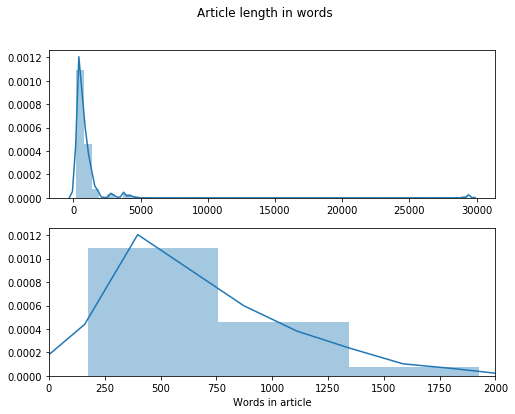

In [10]:
import re

words_count = []

for tt in news_body:
    words_count.append( len(re.findall(r'\w+', tt)) )
    
words_count = np.array(words_count)

# Set up the matplotlib figure
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,6))

plt.suptitle("Article length in words")

sns.distplot(words_count, ax=ax1)

sns.distplot(words_count, ax=ax2)
ax2.set_xlim(0, 2000)
ax2.set(xlabel="Words in article")

print("Number of articles with more than 2000 unique words: %d" % np.sum(words_count>2000))

plt.show()
    

## Unique words in the articles

In [11]:
text_clf_without = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer())])
words_without = text_clf_without.fit_transform( news_body ).shape[1]
print("* Number of unique words in the articles without stop words: %d." % text_clf_without.fit_transform( news_body ).shape[1])
print("* Number of unique words in the articles with stop words: %d." % news_body_tfidf.shape[1])
print("* Number of words stop: %d." % (words_without - news_body_tfidf.shape[1]))


* Number of unique words in the articles without stop words: 14106.
* Number of unique words in the articles with stop words: 13775.
* Number of words stop: 331.


## Articles length in unique words

Number of articles with more than 1000 unique words: 1


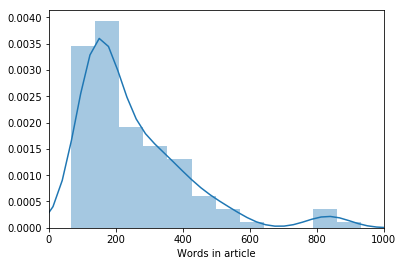

In [12]:
unique_words_count = []
for i in range(news_body_tfidf.shape[0]):
    unique_words_count.append( np.sum(news_body_tfidf[i, :]>0) )
unique_words_count = np.array(unique_words_count)    

ax2 = sns.distplot(unique_words_count)
ax2.set_xlim(0, 1000)
ax2.set(xlabel="Words in article")

print("Number of articles with more than 1000 unique words: %d" % np.sum(unique_words_count>1000))

plt.show()

# Ranking

In [13]:
dd = text_clf.steps[0][1].get_feature_names()

In [14]:
query = "le gouvernement facebook"
# TODO: lowercase query, remove 0 score
cumul_tfidf = np.zeros((116,1))

words_to_query = []
for w in query.split():
    if w in dd:
        words_to_query.append(dd.index(w))
    elif w in stop_words:
        print(w + " is a stop word.")
    else:
        print(w + " doesn't appear in any article.")
        
for w_index in words_to_query:
    article_index, _, tfidf_query = find(news_body_tfidf[:, w_index])
    for index, a_index in enumerate(article_index):
        cumul_tfidf[a_index] = cumul_tfidf[a_index] + tfidf_query[index]
        
sort_articles = cumul_tfidf.argsort(axis=0)[::-1].flatten() # Descending sorting
for i in sort_articles[0:10]:
    print(" * " + feats[i]['title'])
    print(" ----> Score: " + str(cumul_tfidf[i]) )

le is a stop word.
 * L’intégrité de Facebook « plus importante que les profits », selon Mark Zuckerberg
 ----> Score: [ 0.35950176]
 * Entrée à l’université : la sélection toujours au cœur du débat
 ----> Score: [ 0.16659863]
 * La numéro deux du gouvernement espagnol présentée à tort comme la fille d’un général franquiste
 ----> Score: [ 0.15708136]
 * Catalogne : Puigdemont, sous le coup d’un mandat d’arrêt européen, disposé à être candidat
 ----> Score: [ 0.09479473]
 * La bataille continue sur la réserve parlementaire
 ----> Score: [ 0.08933527]
 * L’Assemblée vote des coupes claires dans les aides au logement
 ----> Score: [ 0.08215112]
 * Richard Ford : « Nous, Américains, avons perdu de vue la vérité »
 ----> Score: [ 0.0810098]
 * Fin de la sécu étudiante : colère et inquiétude des mutuelles
 ----> Score: [ 0.07525073]
 * Attaque à New York, Catalogne, harcèlement : les actualités à retenir cette semaine
 ----> Score: [ 0.06875084]
 * Le bonus-malus : « Une juste responsabilis

# Remove accent characters

In [16]:
import unicodedata

accent_str = "Eric jean-paul, àâæçéèêëïîôœùûüÿŸÜÛÙÀÂÆÇÉÈÊËÏÎÔŒ"
unicodedata.normalize('NFKD', accent_str).encode('ASCII', 'ignore').decode("utf-8")

'Eric jean-paul, aaceeeeiiouuuyYUUUAACEEEEIIO'